# Overview and Understanding
For this capstone project I will be working on identifying online harassment using NLP.  Why focus on harassment?  Well, for starters, it's a problem that affects a quarter of the population in the U.S.  Additionally, according to a [2021 Pew research poll]( (https://www.pewresearch.org/internet/2021/01/13/the-state-of-online-harassment/)), 79% of respondants "say social media companies are doing an only fair or poor job at addressing online harassment or bullying on their platforms."  Our goal is to construct a virtual moderator, or vMOD, a NLP model that is capable of predicting if a comment is harassment or not, and automatically blocks users who are sending hateful comments.


"Fully 33% of women under 35 say they have been sexually harassed online", For those who identify as LBGTQA, "51% have been targeted for more severe forms of online abuse."

"Among adults who have been harassed online, roughly half of women (47%) say they think they have encountered harassment online because of their gender, whereas 18% of men who have been harassed online say the same. Similarly, about half or more Black (54%) or Hispanic online harassment targets (47%) say they were harassed due to their race or ethnicity, compared with 17% of White targets."


[Plos article](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0221152)


Use of social media trancends mere entertainment, and often social media sites function as conduits of information and public sentiment.  As such, their use can have catastophic consequence when manipulated by a savy few.  Monitoring hate speech, and the toxic impact it can have on the fragile fabric of our social contracts is a vital and neccessary checkpoint in our information age.

Our goal is to devlop a model that is capable of detecting toxic speech that could be used to both monitor and moderate social media accounts for language designed to inflame and marginalize.

# Data Understanding


Our data comes from a Kaggle competetion, [Identifying Toxic Comments: Jigsaw Toxic Comment Classification Challange](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data),  a dataset comprising of 159571 data points (or comments) from Wikipedia and six target variables, toxic, severe_toxic, obscene, threat, insult, and identity_hate.  The compition was originally hosted by ConversationAI, a research arm of Alphabet.  Because the file is too large to upload to Git, I downloaded the 3 files to my cloud drive (this may take a couple of minutes depending on your download speed).  I then accessed these using OS commands to find  the directory and access said files.

  *Please see markdown below for specific directions on locating and accessing data in collab.*


Per [A Literature Survey on Algorithms for Multi-label
Learning](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.364.5612&rep=rep1&type=pdf) "in multi-label classification, predictions for an instance is a set of labels and, therefore, the prediction
can be fully correct, partially correct (with different levels of correctness) or fully incorrect. None of
these existing evaluation metrics capture such notion in their original form. This makes evaluation
of a multi-label classifier more challenging than evaluation of a single label classifier."

With this in mind we start with with all six targets present, and then try using a binary encoded version of our model for performance comparisons.


## Import Data
In this section we'll take a preliminary look at our data to get a feel for what we're working with. Let's begin with our import statements and then by taking a look at the contents of our train data directory.

In [ ]:
import re, os, csv
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from google.colab import drive


import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, SpatialDropout1D, BatchNormalization
from keras.preprocessing import sequence


import shutil
from gensim.models import Word2Vec

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as Pipe



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
 # Get current directory
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [ ]:
# Set path to data.  Hint- right click on the file you want to copy file path!
drive_path = '/content/drive/MyDrive/Colab_Notebooks/jigsaw-toxic-comment-classification-challenge.zip'

In [ ]:
# Navigate to file
!cp '{drive_path}' .

In [ ]:
# Get current directory/confirm correct path
print(os.getcwd())

# Get contents of the directory
print(os.listdir())

/content
['.config', 'drive', 'jigsaw-toxic-comment-classification-challenge.zip', 'sample_data']


In [ ]:
# Unzip zip file
!unzip '/content/jigsaw-toxic-comment-classification-challenge.zip'

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [ ]:
# import csv data as pd df
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
test_labels= pd.read_csv('test_labels.csv.zip')


## Inspect Data

In [ ]:
train.shape

(159571, 8)

In [ ]:
print("Number of Train NaN:", train['comment_text'].isnull().sum())
print("Number of Test NaN:", test['comment_text'].isnull().sum())
print("Number of Label NaN:", test_labels.isnull().sum())


Number of Train NaN: 0
Number of Test NaN: 0
Number of Label NaN: id               0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
len = train.comment_text.len()
print("Shortest comment:", len.min(), "words")
print("Longest comment:", len.max(), "words")
print("Average comment:", len.mean().round(0), "words")




Shortest comment: 6 words
Longest comment: 5000 words
Average comment: 394.0 words


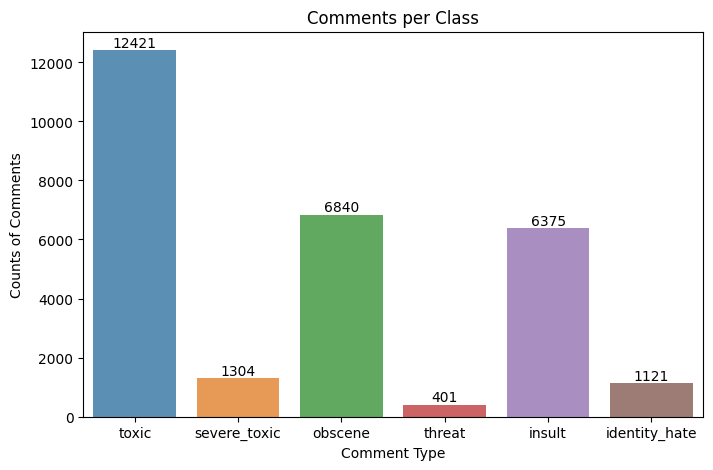

In [ ]:
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

val_counts = y_train[cols].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x= val_counts.index, y= val_counts.values, alpha=0.8)

plt.title("Comments per Class")
plt.xlabel("Comment Type")
plt.ylabel("Counts of Comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")


plt.show()

In [ ]:
# Find total number of toxic comments in train
x=train.iloc[:,2:].sum()
print("Total number of toxic comments:", x.sum())


Total number of toxic comments: 35098


### Class Imbalance
We can see there is a clear class imbalance in our data-only 35,098 comments are considered toxic, out of our dataset of 159,571; far more records have no toxic languge than do.  We'll need to take this into account when building our model.


## Train, Test, Val Split

In order to ensure our data has no leakage, we'll perform an intitial train test split before cleaning our corpus

In [ ]:
# Train dataframes
Xtrain = train['comment_text']
ytrain = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]


In [ ]:
#Train test split
X_train_1, X_test, y_train_1, y_test = train_test_split(Xtrain, ytrain,
                                                    test_size=0.15, random_state=42)


In [ ]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
 X_train, X_val, y_train, y_val= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [ ]:
# Examine train test val
print("Train Comments:", X_train.head(2))
print("--------------------------------")

print("Test Comments:", X_test.head(2))
print("--------------------------------")

print("Val Comments:", X_val.head(2))
print("--------------------------------")

print("Train Target Variables:", y_train.head(2))
print("--------------------------------")

print("Test Target Variables:", y_test.head(2))
print("--------------------------------")

print("Val Target Variables:", y_val.head(2))
print("--------------------------------")


Train Comments: 159023    service award\nhello. i noticed you list yours...
76867     "\nwelcome!hello and welcome to wikipedia. tha...
Name: comment_text, dtype: object
--------------------------------
Test Comments: 119105    geez, are you forgetful!  we've already discus...
131631    carioca rfa \n\nthanks for your support on my ...
Name: comment_text, dtype: object
--------------------------------
Val Comments: 7608     "\n ok, i understand. -) i've been a racist fo...
20119    again again again \n\nthis is not going to sto...
Name: comment_text, dtype: object
--------------------------------
Train Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
159023      0             0        0       0       0              0
76867       0             0        0       0       0              0
--------------------------------
Test Target Variables:         toxic  severe_toxic  obscene  threat  insult  identity_hate
119105      0             0        0       0

# Data Preprocessing

We'll untertake our next step, tokenizing our corpus, or splitting each comment into a series of words.  We'll have to make some decisions now about whether we remove stop words, what kinds of regex expressions we should use to clean the comments, if we should stem, lemmatize, or leave our text data as is before we come to our next step, vectorization.

Because our dataset is quite large, we'll begin by removing stop words- large datasets become highly dimensionsal after they've been vectorized, and to minimize processing times we'll need to reduce the amount of tokens we pass in to our vector.  Removing stop words- the most common words in english that have little value in this use case, will help us do so.  However, we'll keep the word "not" in our corpus, as it's use to negate bad sentiment seems highly relevant to determining the toxicity of a comment.

We'll also use regex expressions to clean up our comments by removing blanskspaces, web adresses, new line notation, non-words, and non ascii words.

We'll hold off on stemming or lemmatizing for now.  If our results from our initial models are unsatisfactory, we'll circle back to stemming our tokens.


### Clean Corpus

In [ ]:
STOPWORDS = set(stopwords.words('english')) - {'not', 'no' }
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text) # remove all non words
    text = re.sub('\s+', ' ', text) #remove whitespace
    text = re.sub(r"https?://\S+|www\.\S+", "", text) # remove websites
    text = re.sub(r'[^\x00-\x7f]',r'', text) # remove non ACSII char
    text = re.sub(r"\n", "", text) # remove newline
    text = text.strip(' ')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text


    return text

In [ ]:
X_train = X_train.map(lambda com : clean_text(com))
X_test = X_test.map(lambda com : clean_text(com))
X_val = X_val.map(lambda com : clean_text(com))



In [ ]:
# Check lengths of comments
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    128853.000000
mean         37.138491
std          57.355683
min           1.000000
25%           9.000000
50%          20.000000
75%          41.000000
max        1250.000000
Name: comment_text, dtype: float64

We're checking the length of our comments to see what the average input length is- if we utilize more advanced modelling techniques each comment will need to be the same length, and so it will be important to discern what a good middle ground for shortening or padding our sequences will be.  In this case, our comments average about 37 words after cleaning.  With a STD of 57, and a max count of 1250, we'd do well to err on the larger size.

# Bayes's Theorem
"...with NB models generally
outperforming the sophisticated, structure-sensitive
models explored in recent work. Furthermore, by
combining generative and discriminative classifiers,
we present a simple model variant where an SVM is
built over NB log-count ratios as feature values, and
show that it is a strong and robust performer over all
the presented tasks"

 Multinomial Naive Bayes (MNB) better att snippets.  Support Vector Machine (SVM) better at full length and  SVM with NB(Naive Bayes) features (NBSVM) doing well on both
[Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf)



# Vectorization
In order to model and make predictions with our data we'll need to tranform our word tokens into vectors, or an array of numbers.

Vectorization allows our model to:
* Find word predictions
* Find word similarities
* Represent words in a lower-dimensional space
* Allow words with similar meanings to have a similar representation
* Approximate meaning

The most straightforward vectorizer in sklearn.feature_extraction.text is the CountVectorizer, which will simply count the number of each word type in each document.  Two other strategies include:

* Bag of Words: A a simple, yet effective text encoding technique. Corpus is tokenized, only unique words are selected to create the vocabulary and then sorted by alphabetical order.  Single words or n-grams can be used for analysis.

* TF-IDF: Term Frequency–Inverse Document Frequency, is a numerical statistic that’s intended to reflect how important a word is to a document.  This is a slightly more sophisticated version of bag of words.

We'll use a pipeline to send both the CountVectorizer and TfidfTransformer vectors through a Multinomial Naive Bayes classifier, wrapping that in a MultiOutputClassifier to account for our 6 target variables.



Build pipeline

In [ ]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultiOutputClassifier(MultinomialNB()))
               ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print("----------------------------------------------------")
print("Test Classification Report", classification_report(y_test, y_pred,target_names=y_test.columns))



accuracy 0.9015290775401069
               precision    recall  f1-score   support

        toxic       0.99      0.18      0.30      2260
 severe_toxic       0.00      0.00      0.00       225
      obscene       0.99      0.11      0.20      1279
       threat       0.00      0.00      0.00        53
       insult       0.98      0.05      0.10      1192
identity_hate       0.00      0.00      0.00       227

    micro avg       0.99      0.12      0.21      5236
    macro avg       0.49      0.06      0.10      5236
 weighted avg       0.89      0.12      0.20      5236
  samples avg       0.02      0.01      0.01      5236



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision Measures the accuracy of positive predictions. It quantifies the number of positive class predictions that actually belong to the positive class. We had a very small percentage of false positives, only 1%


Recall Measures the completeness of positive predictions. It quantifies the number of positive class predictions made out of all positive examples in the dataset.  The recall of our model was very poor, only 12%  of our total positives were captured.

F1 scores are the harmonic mean of precision and recall, and often is more accurate than looking solely at precision.  From our F1 scores of 30%, we can see that we're doing a poor job using a multioutput model.  Let's see if switching it to a binary output helps to improve our ability to identify toxic speech.


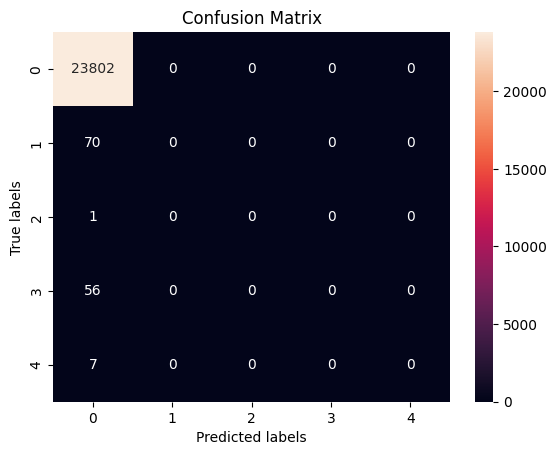

In [ ]:
lables = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_pred = np.argmax(nb.predict(X_test), axis=1)
thresh = 0.5
y_pred = (y_pred > thresh)

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, label=lables);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');



We can see that our classifier was unable to identify any toxic speech, instead labelling all speech as non-toxic.  This is likely due to our class imbalance.  In order to address that, we'll binarize our data (toxic speech is, after all, toxic speech regardless of it's form), in order to oversample our minority class.



## Binary target
We'll use exactly the same preprocessing AND resampling using RandomOverSampler to account for our class imbalance with our target data reshaped as binary below.

In [ ]:
# Binarize target variables by converting all 6 types of toxic speech to 1 if cols= 'toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'

cols=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
train['Toxic']=train[cols].max(axis=1).apply(lambda x: 1 if x ==1 else 0)

In [ ]:
# Check encoding
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
# Train test dataframes
train_bi = train['comment_text'].str.lower()
ytrain_bi = train['Toxic']


In [ ]:
#Train test split
X_train_1, X_test_bi, y_train_1, y_test_bi = train_test_split(train_bi, ytrain_bi,
                                                    test_size=0.15, random_state=42)


In [ ]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
X_train_bi, X_val_bi, y_train_bi, y_val_bi= train_test_split(X_train_1, y_train_1,
                                                    test_size=0.05, random_state=42)

In [ ]:
X_train_bi = X_train_bi.map(lambda com : clean_text(com))
X_test_bi = X_test_bi.map(lambda com : clean_text(com))
X_val_bi = X_val_bi.map(lambda com : clean_text(com))

In [ ]:
nb2 = Pipe([('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('sampler', RandomOverSampler()),
            ('clf', MultinomialNB()),
])
nb2.fit(X_train_bi, y_train_bi)

y_pred_bi = nb2.predict(X_test_bi)

print('accuracy %s' % accuracy_score(y_pred_bi, y_test_bi))
print(classification_report(y_test_bi, y_pred_bi))

accuracy 0.8978108288770054
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     21542
           1       0.49      0.87      0.63      2394

    accuracy                           0.90     23936
   macro avg       0.74      0.89      0.79     23936
weighted avg       0.94      0.90      0.91     23936



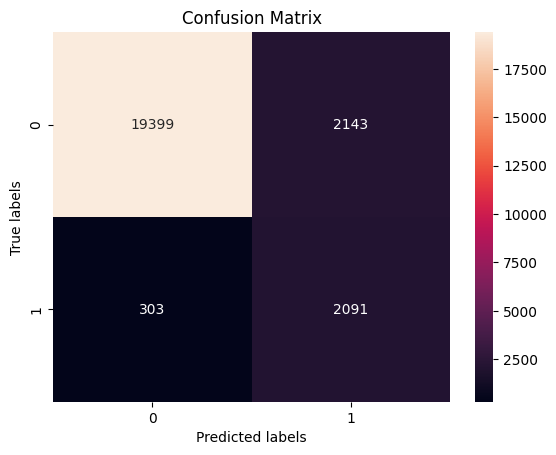

In [ ]:
ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_test_bi), y_pred_bi)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

This model does a much better job of identifying toxic speech, although we've got 303 cases of normal speech falsely being categorized as toxic here, and more worrisome, over 1/2 our toxic speech being classified as non-toxic.  Let's see if using a neural network can reduce our false positives and improve our ability to identify toxic speech



#  Model Using W2V Embeddings
An embedding is a mapping of a discrete — categorical — variable to a vector of continuous numbers. In the context of neural networks, embeddings are low-dimensional, learned continuous vector representations of discrete variables. Neural network embeddings are useful because they can reduce the dimensionality of categorical variables and meaningfully represent categories in the transformed space.

Neural network embeddings have 3 primary purposes:

1.  Finding nearest neighbors in the embedding space. These can be used to make recommendations based on user interests or cluster categories.
2.  As input to a machine learning model for a supervised task.
3.  For visualization of concepts and relations between categories.

This makes modelling using embeddings the perfect choice for this task- we're looking to find the relationship between certain tokens and classification of speech as toxic. In particular, Word2Vec captures semantic relationships between words. Words with similar meanings tend to have similar vector representations, allowing it to understand word context and similarity.  We'll see if this applies to our test data in this application.

We'll use the following parameters:

- window: Determines the number of words before and after the target word to be considered as context for the word
- min_count: Determines the number of times a word must occur in the text corpus for a word vector to be created

In [ ]:
from keras.layers import LSTM
from gensim.models import KeyedVectors


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_bi, ytrain_bi, test_size=0.2)

w2v = Word2Vec([sentence.lower().split() for sentence in x_train.values])

maxlen = 100
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train_sequences,
                                maxlen=100,
                                padding='post',
                                truncating='post')

x_test = pad_sequences(x_test_sequences,
                             maxlen=100,
                             padding='post',
                             truncating='post')

embedding_matrix = np.zeros((len(word_index)+1, 100))
for word,i in word_index.items():
    try:
        embedding_matrix[i] = w2v.wv[i]
    except:
        embedding_matrix[i] = np.zeros(100)


ValueError: ignored

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(183624, 100, input_length=100,
        weights=[embedding_matrix], trainable=False),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', metrics=['acc'],
        loss='sparse_categorical_crossentropy')

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)

# Making things BERT friendly

Encoder models use only the encoder of a Transformer model. At each stage, the attention layers can access all the words in the initial sentence. These models are often characterized as having “bi-directional” attention, and are often called auto-encoding models.

The pretraining of these models usually revolves around somehow corrupting a given sentence (for instance, by masking random words in it) and tasking the model with finding or reconstructing the initial sentence.

Encoder models are best suited for tasks requiring an understanding of the full sentence, such as sentence classification, named entity recognition (and more generally word classification), and extractive question answering.

BERT, which stands for Bidirectional Encoder Representations from Transformers, is a cutting edge pretrained black box NLP model developed by Google.  

"Transformers are a multi-head attention mechanisms that learns contextual relations between the words in the given text.
Generally, a transformer consists of two separate parts - an encoder that accepts the text input and an optional
decoder or a sigmoid/softmax layer that produces a prediction for the task. BERT is a pre-training approach that uses
this architecture for modeling." [Toxic Comment Classification using Transformers](https://www.ieomsociety.org/singapore2021/papers/366.pdf)


The tokenizer returns a dictionary with three important items:

* input_ids are the indices corresponding to each token in the sentence.
* attention_mask indicates whether a token should be attended to or not.
* token_type_ids identifies which sequence a token belongs to when there is more than one sequence.

Special thanks to HARSH JAIN for their Kaggle article [BERT for "Everyone"](https://www.kaggle.com/code/harshjain123/bert-for-everyone-tutorial-implementation), from which much of the following code is excerpted.


First let's make the data compliant with BERT-
There is a very helpful function, encode_plus provided in the Tokenizer class which performs the following operations:

Tokenize the text
* Add special tokens - [CLS] and [SEP]
* create token IDs
* Pad the sentences to a common length
* Create attention masks for the above PAD tokens



We'll begin with our import statements:



In [ ]:
! pip install accelerate
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset

from tqdm.notebook import tqdm

import transformers
from transformers import AutoTokenizer, TrainingArguments, Trainer, BertModel, pipeline, BertForSequenceClassification
from transformers import AdamW

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')


## Train, Test Val split

In [ ]:
#new df with binary data
train_b = train[['Toxic', 'comment_text']]

In [ ]:
#Train test split
X_train_B, X_test_BERT = train_test_split(train_b, test_size=0.15, random_state=42)


In [ ]:
 # Val split *Validation data abels for the test data could not be used per Kaggle "value of -1 indicates it was not used for scoring; (Note: file added after competition close!)"
X_train_BERT, X_val_BERT= train_test_split(X_train_B, test_size=0.05, random_state=42)

In [ ]:
X_train_BERT.reset_index(drop=True, inplace=True)
X_val_BERT.reset_index(drop=True, inplace=True)
X_test_BERT.reset_index(drop=True, inplace=True)


## Check GPU
In order to run BERT will need the increased processing power of a GPU.  We can discover which (if any) processor we're using by running the following code:

In [ ]:
"""# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
      raise SystemError('GPU device not found')
"""

Found GPU at: /device:GPU:0


## Tokenize Text and Convert to Tensors


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
MAX_LEN = 125
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 1

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = dataframe.Toxic
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return [
            torch.tensor(input_ids, dtype=torch.long),
            torch.tensor(attention_mask, dtype=torch.long),
            torch.tensor(token_type_ids, dtype=torch.long),
            torch.tensor(self.targets[index], dtype=torch.float)
        ]

In [ ]:
training_set = CustomDataset(X_train_BERT, tokenizer, MAX_LEN)
testing_set = CustomDataset(X_test_BERT, tokenizer, MAX_LEN)
val_set = CustomDataset(X_val_BERT, tokenizer, MAX_LEN)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
val_loader = DataLoader(val_set, **val_params)

In [ ]:
# Creating the customized model for sentiment analysis by
# adding a sigmoid activation function onto the end of the linear layer

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768,2)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(input_ids, attention_mask, token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:

training_args = TrainingArguments(
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate= 2e-5,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model= "precision",
    output_dir="./",
)

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    tokenizer=tokenizer,
    eval_dataset=val_set
)

In [ ]:
trainer.train()


AttributeError: ignored

       Error caused by:
        # The model's main input name, usually `input_ids`, has be passed for padding


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


Trying to compute gradients for a tensor with multiple elements
Using the wrong loss function
Using the wrong activation function

## different approach

In [ ]:
# create labels column
cols = ds["train"].column_names
ds = ds.map(lambda x : {"labels": [x[c] for c in cols if c != "comment_text"]})
ds

## Tokenize and encode

In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
def tokenize_and_encode(examples):
  return tokenizer(examples["comment_text"], truncation=True)

In [ ]:
cols = ds["train"].column_names
cols.remove("labels")
ds_enc = ds.map(tokenize_and_encode, batched=True, remove_columns=cols)
ds_enc

Loading cached processed dataset at /root/.cache/huggingface/datasets/jigsaw_toxicity_pred/default-2e028684d09fa340/1.1.0/7475ac9e42901c300e7d6f5ff9f1e234a46b3e90c377c1c900da4fd2f7738dbf/cache-13b55004b3b20c8d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/jigsaw_toxicity_pred/default-2e028684d09fa340/1.1.0/7475ac9e42901c300e7d6f5ff9f1e234a46b3e90c377c1c900da4fd2f7738dbf/cache-1e115761ef12b984.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 200
    })
})

In [ ]:
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to('cuda')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
multi_trainer = MultilabelTrainer(
    model,
    args,
    train_dataset=ds_enc["train"],
    eval_dataset=ds_enc["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer)

In [ ]:
multi_trainer.train()